In [1]:
from time import sleep
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def scrape_reviews(path, n_pages, sleep_time=0.3):
    names = []
    ratings = []
    headers = []
    reviews = []
    dates = []
    locations = []
    
    for page in range(n_pages):
        sleep(sleep_time)
        
        response = get(f'{path}{page}')
        page_html = BeautifulSoup(response.text, 'html.parser')
        review_containers = page_html.find_all('div', class_='styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ')
        
        
        for review in review_containers:
            name = review.a.find('span', class_='typography_heading-xxs__QKBS8 typography_appearance-default__AAY17').text
            names.append(name)
            
            rating = int(review.section.find('div', class_='styles_reviewHeader__iU9Px')['data-service-review-rating'])
            ratings.append(rating)
            
            header = review.find('h2', class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
            if header:
                headers.append(header.text)
            else:
                header.append('No header')
            
            review_n = review.find('p', class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
            if review_n:
                reviews.append(review_n.text)
            else:
                reviews.append('No review')
            
            date = review.time['datetime'].split('T')[0]
            dates.append(date)
            
            location = review.a.find('div', class_='typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua')
            if location:
                locations.append(location.text)
            else:
                locations.append('No location')

    df = pd.DataFrame(
    {
        'Name': names,
        'Rating': ratings,
        'Header': headers,
        'Review': reviews,
        'Date': dates,
        'Location': locations
    }
    )
    return df
df = scrape_reviews(path='https://www.trustpilot.com/review/westernunion.com?languages=all&page=', n_pages=300)

In [3]:
response_2 = get('https://efi-trans.com.ua/info/ISO_country_codes/')
page = BeautifulSoup(response_2.text, 'html.parser')
containers = page.find_all('tr', attrs={'valing':'top'})

country = []
abbreviation = []

for container in containers[1:]:
    val = container.find_all('td')
    country.append(val[0].text)
    abbreviation.append(val[2].text)

abbreviations = dict(zip(abbreviation, country))

In [4]:
df['Location'] = df['Location'].map(abbreviations)
df

,Name,Rating,Header,Review,Date,Location
0,"Carol E Richardson, MDiv, MPH",3,Every time I try to redeem points to…,Every time I try to redeem points to save myse...,2023-01-22,United States of America
1,Carolyn Smith,3,The website is not very user friendly,The website is not very user friendly! I hav...,2023-01-23,United States of America
2,Lee,1,No rewards ever,"I am unable, repeatedly, to use my reward poin...",2023-01-22,United States of America
3,Jeremy,1,Tried to redeem points (again) and…,Tried to redeem points (again) and (again) the...,2023-01-20,United States of America
4,Chuck Heschmeyer,2,Exchange Rate Ripoff,In sending $ from the USA to Colombia or Costa...,2023-01-21,United States of America
...,...,...,...,...,...,...
5975,NATALIE,5,Good App,"Fast, low fees and in time.",2022-09-03,United States of America
5976,GREG,2,Transfer would not complete to Ghana.,Transfer would not complete to Ghana.Some rule...,2022-09-03,United States of America
5977,LILIA,5,Great service,No review,2022-09-02,United States of America
5978,Nicholas,1,I am sorry but I have a different…,I am sorry but I have a different agency to se...,2022-09-02,United States of America


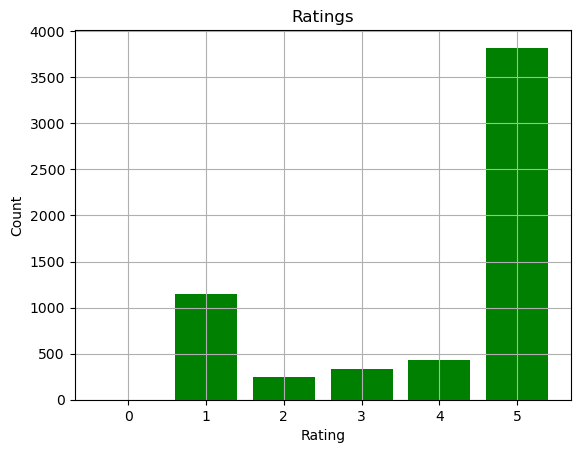

In [5]:
fig, ax = plt.subplots()
rates = df['Rating'].value_counts().sort_index()
ax.bar(rates.index, rates.values, color='green')
ax.grid()
ax.set_ylabel('Count')
ax.set_xlabel('Rating')
ax.set_title('Ratings')
plt.show()

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year_month'] = df['Date'].dt.to_period('M').dt.strftime('%Y-%m')

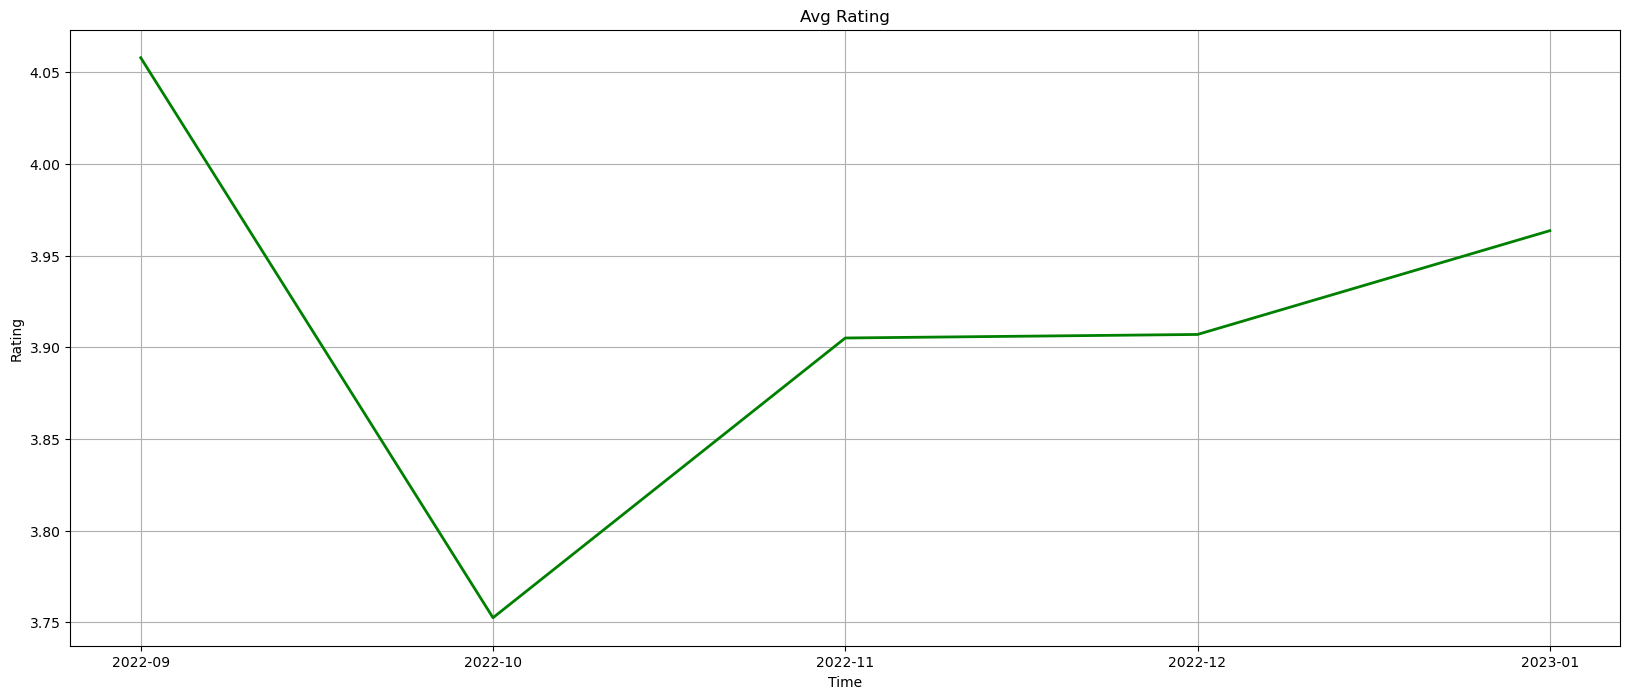

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
dd = (df.groupby(df['Year_month']).mean()).reset_index()[['Year_month', 'Rating']]

x = dd['Year_month']
y = dd['Rating']

ax.plot(x, y, color='green', linewidth=2)
ax.grid()
ax.set_ylabel('Rating')
ax.set_xlabel('Time')
ax.set_title('Avg Rating')
ax.set_xticks(df['Year_month'].unique())
plt.show()

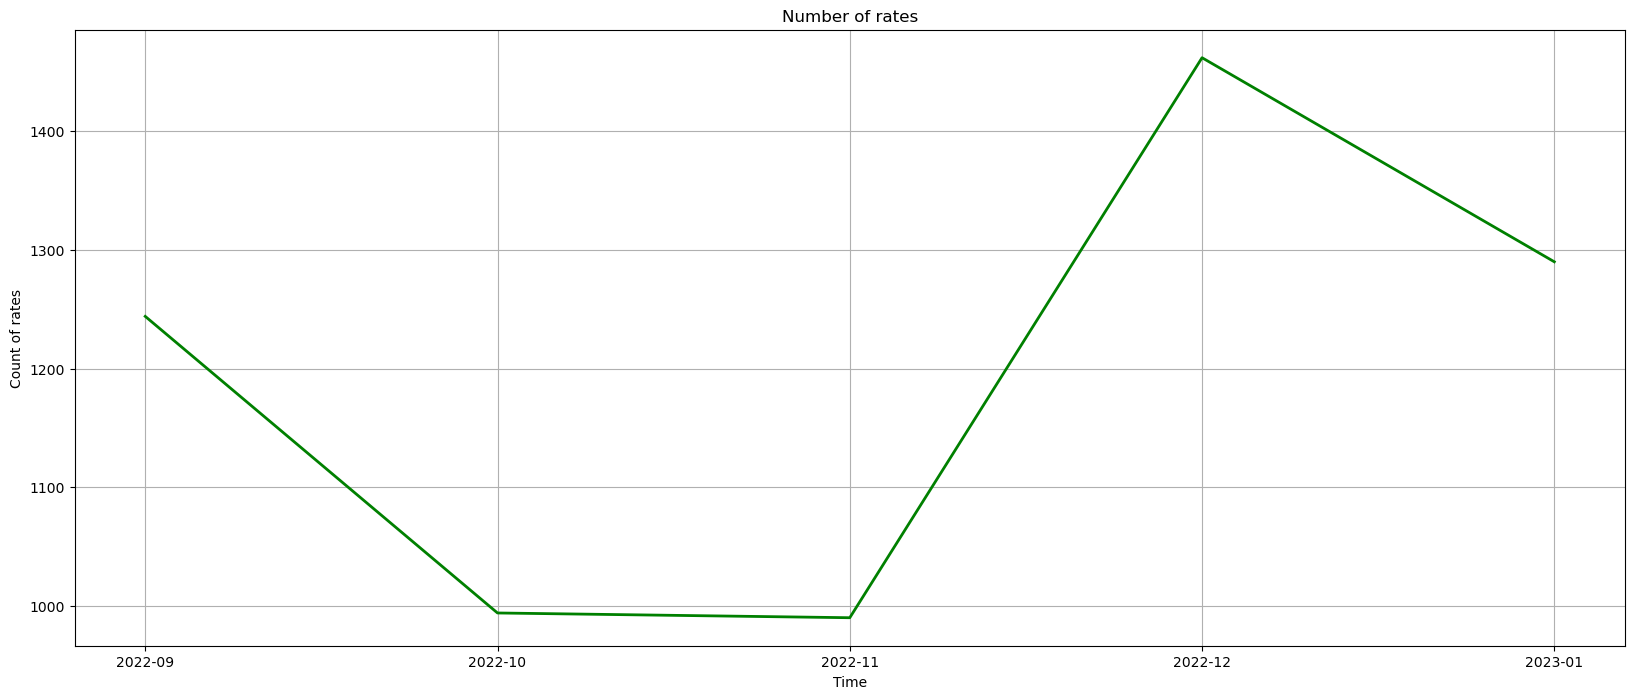

In [8]:
fig, ax = plt.subplots(figsize=(20, 8))
dd = (df.groupby(df['Year_month']).count()).reset_index()[['Year_month', 'Rating']]
x = dd['Year_month']
y = dd['Rating']

ax.plot(x, y, color='green', linewidth=2)
ax.grid()
ax.set_ylabel('Count of rates')
ax.set_xlabel('Time')
ax.set_title('Number of rates')
ax.set_xticks(df['Year_month'].unique())
plt.show()

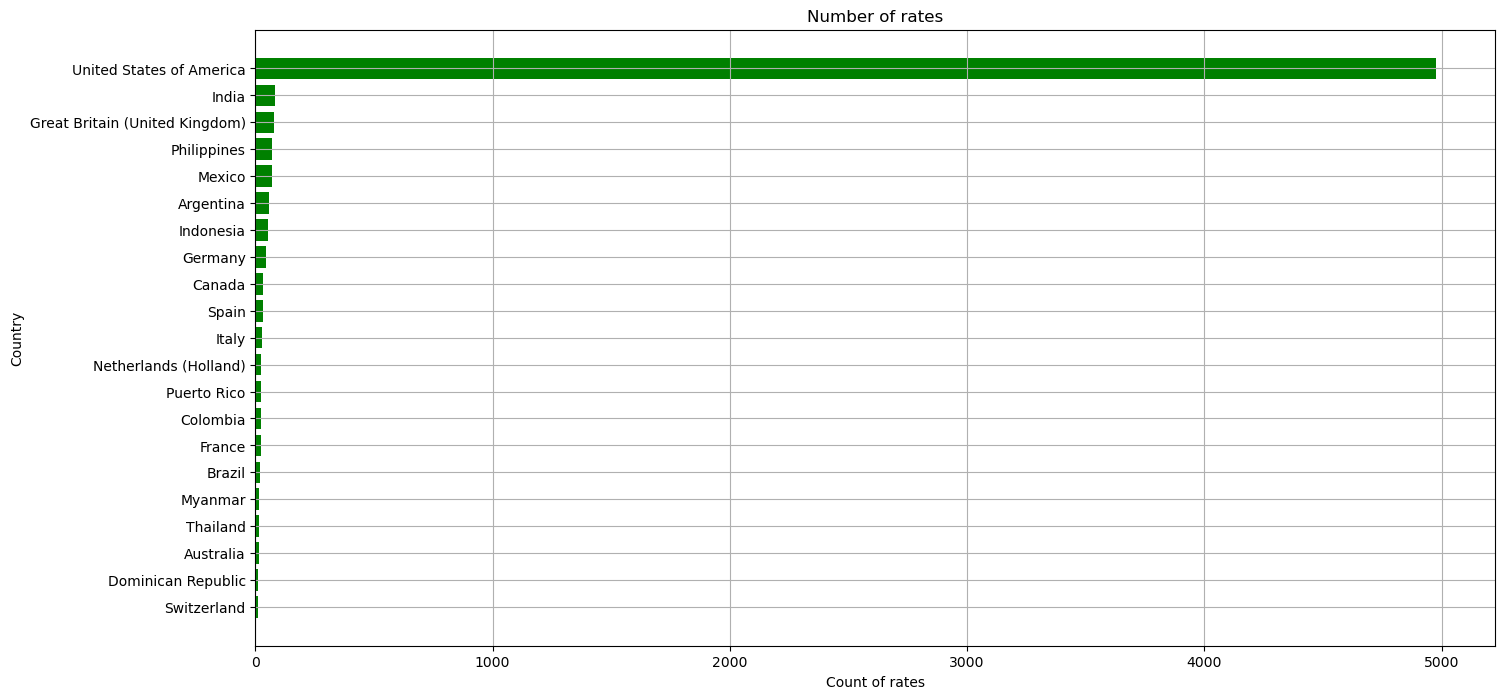

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
dt = (df.groupby(['Location']).count()).reset_index()[['Location', 'Rating']]
dd = dt[dt['Rating'] > 10]
dd = dd.sort_values(by=['Rating'])
x = dd['Location']
y = dd['Rating']
ax.barh(x, y, color='green')
ax.grid()
ax.set_ylabel('Country')
ax.set_xlabel('Count of rates')
ax.set_title('Number of rates')
plt.show()

<AxesSubplot:xlabel='Location'>

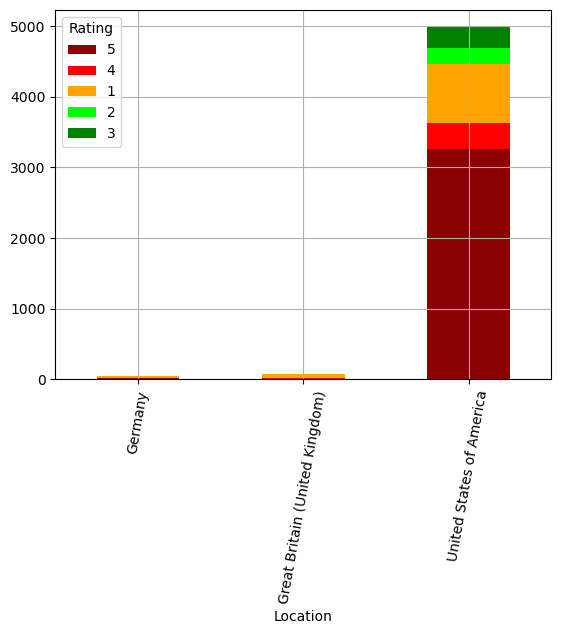

In [11]:
dd = df.groupby(['Location', 'Rating']).size().unstack()
dd = dd[dd[1] > 20]
countries = dd.index.values
dd.plot(kind='bar', stacked=True, grid=True, rot=80, color=['darkred', 'red', 'orange', 'lime', 'green'])

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Islam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Islam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Islam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Islam\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
dd = df.loc[df['Location'].isin(countries)]
dd = dd[dd['Rating'] == 1]

lemmatizer = WordNetLemmatizer()
tokens = []
for review in dd.Review:
    tokens.append(word_tokenize(review))

tokenization = []
for token in tokens:
    tokenization.extend([lemmatizer.lemmatize(w.casefold()) for w in token if w.casefold() not in [*stopwords.words('english'), *string.punctuation]])

bigrams = nltk.bigrams(tokenization)
frequency = dict(nltk.FreqDist(bigrams))

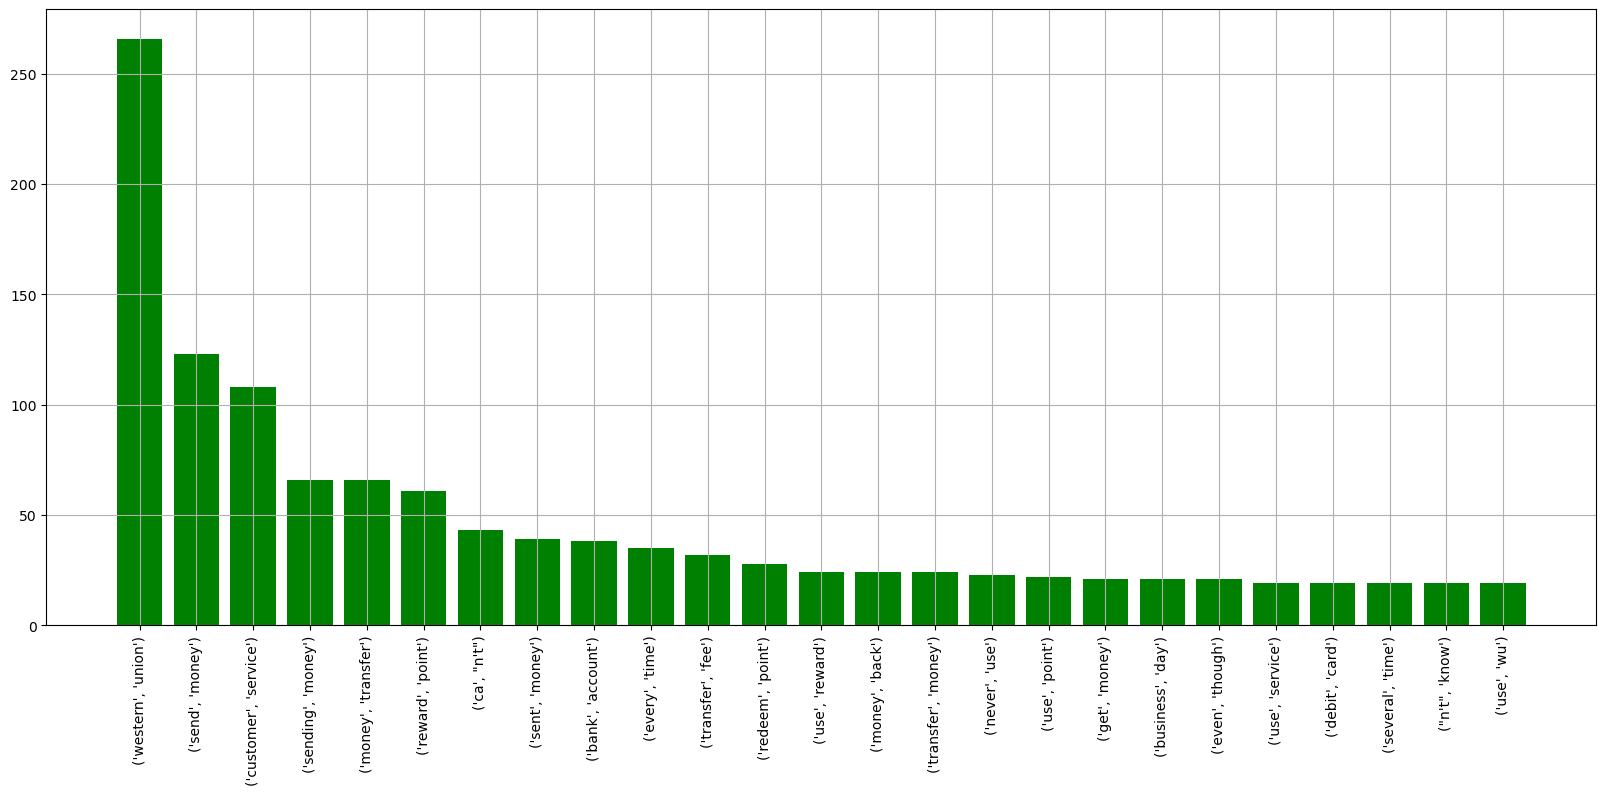

In [14]:
sorted_bigrams = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))

x = [*sorted_bigrams.keys()][:25]
y = [*sorted_bigrams.values()][:25]

plt.figure(figsize=(20, 8))

plt.bar(range(len(x)), y, color='green')
plt.xticks(range(len(x)), x, rotation=90)
plt.grid(True)
plt.show()